## Preprocess pan-cancer RPPA data

Load the downloaded data and curate sample IDs.

In [11]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.tcga_utilities as tu

### Read TCGA Barcode Curation Information

Extract information from TCGA barcodes - `cancer-type` and `sample-type`. See https://github.com/cognoma/cancer-data for more details

In [2]:
# commit from https://github.com/cognoma/cancer-data/
sample_commit = 'da832c5edc1ca4d3f665b038d15b19fced724f4c'
url = 'https://raw.githubusercontent.com/cognoma/cancer-data/{}/mapping/tcga_cancertype_codes.csv'.format(sample_commit)
cancer_types_df = pd.read_csv(url,
                              dtype='str',
                              keep_default_na=False)

cancertype_codes_dict = dict(zip(cancer_types_df['TSS Code'],
                                 cancer_types_df.acronym))
cancer_types_df.head(2)

,TSS Code,Source Site,Study Name,BCR,acronym
0,01,International Genomics Consortium,ovarian serous cystadenocarcinoma,IGC,OV
1,02,MD Anderson Cancer Center,glioblastoma multiforme,IGC,GBM


In [3]:
url = 'https://raw.githubusercontent.com/cognoma/cancer-data/{}/mapping/tcga_sampletype_codes.csv'.format(sample_commit)
sample_types_df = pd.read_csv(url, dtype='str')

sampletype_codes_dict = dict(zip(sample_types_df.Code,
                                 sample_types_df.Definition))
sample_types_df.head(2)

,Code,Definition,Short Letter Code
0,01,Primary Solid Tumor,TP
1,02,Recurrent Solid Tumor,TR


### Load and process RPPA data

In [4]:
# first load manifest file, this tells us the filenames of the raw data files
manifest_df = pd.read_csv(os.path.join(cfg.data_dir, 'manifest.tsv'),
                          sep='\t', index_col=0)
manifest_df.head(5)

,id,filename,md5,size
name,,,,
mirna_sample,55d9bf6f-0712-4315-b588-e6f8e295018e,PanCanAtlas_miRNA_sample_information_list.txt,02bb56712be34bcd58c50d90387aebde,553408
methylation_27k,d82e2c44-89eb-43d9-b6d3-712732bf6a53,jhu-usc.edu_PANCAN_merged_HumanMethylation27_H...,5cec086f0b002d17befef76a3241e73b,5022150019
methylation_450k,99b0c493-9e94-4d99-af9f-151e46bab989,jhu-usc.edu_PANCAN_HumanMethylation450.betaVal...,a92f50490cf4eca98b0d19e10927de9d,41541692788
rppa,fcbb373e-28d4-4818-92f3-601ede3da5e1,TCGA-RPPA-pancan-clean.txt,e2b914c7ecd369589275d546d9555b05,18901234
rna_seq,3586c0da-64d0-4b74-a449-5ff4d9136611,EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2....,02e72c33071307ff6570621480d3c90b,1882540959


In [5]:
tcga_rppa_df = (
    pd.read_csv(os.path.join(cfg.raw_data_dir, manifest_df.loc['rppa'].filename),
                index_col=0, sep='\t')
)

tcga_rppa_df.index.rename('sample_id', inplace=True)

print(tcga_rppa_df.shape)
tcga_rppa_df.iloc[:5, :5]

(7790, 199)


,TumorType,X1433EPSILON,X4EBP1,X4EBP1_pS65,X4EBP1_pT37T46
sample_id,,,,,
TCGA-OR-A5J2-01A-21-A39K-20,ACC,-0.494327,0.592339,0.104604,-0.134915
TCGA-PA-A5YG-01A-21-A39K-20,ACC,-0.535367,0.182801,-0.105769,-0.040087
TCGA-OR-A5JV-01A-21-A39K-20,ACC,-0.109010,0.417659,0.024750,-0.720552
TCGA-OR-A5JT-01A-21-A39K-20,ACC,-0.412523,0.258615,0.005974,0.563042
TCGA-OR-A5JR-01A-21-A39K-20,ACC,-0.288187,-0.112085,0.019447,-0.002671


In [6]:
# update sample IDs to remove multiple samples measured on the same tumor
# and to map with the clinical information
tcga_rppa_df.index = tcga_rppa_df.index.str.slice(start=0, stop=15)
tcga_rppa_df = tcga_rppa_df.loc[~tcga_rppa_df.index.duplicated(), :]
print(tcga_rppa_df.shape)

(7790, 199)


### Filtering/imputation/NA removal

(199,)
CASPASE9        7350
CASPASE3        7350
JAB1            6347
PARP1           6347
TTF1            4937
ALPHACATENIN    4937
ADAR1           4937
ARID1A          3855
BRCA2           1003
EGFR_pY1068        0
dtype: int64


<AxesSubplot:ylabel='Count'>

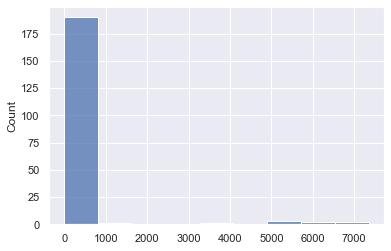

In [7]:
# how many missing values does each probe (column) have?
probe_na = tcga_rppa_df.isna().sum()
print(probe_na.shape)
print(probe_na.sort_values(ascending=False).head(10))
sns.set()
sns.histplot(probe_na)

(7790,)
sample_id
TCGA-CC-A3MA-01    8
TCGA-R8-A6YH-01    8
TCGA-HT-A74J-01    8
TCGA-KT-A74X-01    8
TCGA-TQ-A8XE-01    8
TCGA-P5-A77X-01    8
TCGA-P5-A781-01    8
TCGA-P5-A77W-01    8
TCGA-P5-A780-01    8
TCGA-TQ-A7RW-01    8
dtype: int64


<AxesSubplot:ylabel='Count'>

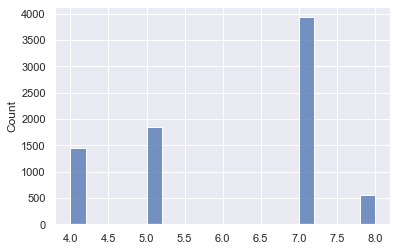

In [8]:
# how many missing values does each sample have?
sample_na = tcga_rppa_df.transpose().isna().sum()
print(sample_na.shape)
print(sample_na.sort_values(ascending=False).head(10))
sns.set()
sns.histplot(sample_na)

In [9]:
# for now, just drop all columns with NAs, since there's only a few
print(tcga_rppa_df.shape)
tcga_rppa_df.dropna(axis='columns', inplace=True)
print(tcga_rppa_df.shape)

# check for duplicate samples
print('Duplicates:', np.count_nonzero(tcga_rppa_df.index.duplicated()))

(7790, 199)
(7790, 190)
Duplicates: 0


### Process TCGA cancer type and sample type info from barcodes

See https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tissue-source-site-codes for more details.

In [12]:
# get sample info and save to file

tcga_id = tu.get_and_save_sample_info(tcga_rppa_df,
                                      sampletype_codes_dict,
                                      cancertype_codes_dict,
                                      training_data='rppa')

print(tcga_id.shape)
tcga_id.head()

(7790, 4)


,sample_id,sample_type,cancer_type,id_for_stratification
0,TCGA-OR-A5J2-01,Primary Solid Tumor,ACC,ACCPrimary Solid Tumor
1,TCGA-PA-A5YG-01,Primary Solid Tumor,ACC,ACCPrimary Solid Tumor
2,TCGA-OR-A5JV-01,Primary Solid Tumor,ACC,ACCPrimary Solid Tumor
3,TCGA-OR-A5JT-01,Primary Solid Tumor,ACC,ACCPrimary Solid Tumor
4,TCGA-OR-A5JR-01,Primary Solid Tumor,ACC,ACCPrimary Solid Tumor


In [13]:
# get cancer type counts and save to file
cancertype_count_df = (
    pd.DataFrame(tcga_id.cancer_type.value_counts())
    .reset_index()
    .rename({'index': 'cancertype', 'cancer_type': 'n ='}, axis='columns')
)

file = os.path.join(cfg.sample_info_dir, 'tcga_me_27k_sample_counts.tsv')
cancertype_count_df.to_csv(file, sep='\t', index=False)

cancertype_count_df.head()

In [18]:
# compare cancer types from sample ID to cancer types provided with data matrix
type_df = (tcga_rppa_df
    .merge(tcga_id, left_index=True, right_on='sample_id')
    .set_index('sample_id')
    .drop(columns=['sample_type', 'id_for_stratification'])
)
neq_df = type_df[type_df.TumorType != type_df.cancer_type]
print(neq_df.shape)
print(neq_df.TumorType.unique())
print(neq_df.cancer_type.unique())
neq_df.head()

Looks like "CORE" is short for "COAD/READ", so all the cancer types match. So, we can just drop the TumorType column and use the sample info saved in the data directory.

In [18]:
rppa_file = os.path.join(cfg.data_dir, 'rppa_preprocessed.tsv')
(tcga_rppa_df
    .drop(columns=['TumorType'])
    .to_csv(rppa_file, sep='\t', float_format='%.3g')
)